In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logging
import time
import os
from skimage import transform

start_time = time.time()

tf.reset_default_graph()
tf.set_random_seed(5)

# Load data
x_train = np.load('exam2_train_x.npy').astype(np.float32)
y_train = np.load('exam2_train_y.npy').astype(int)

x_test = np.load('exam2_test_x.npy').astype(np.float32)
y_test = np.load('exam2_test_y.npy').astype(int)

log = logging.getLogger('tensorflow')
log.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(message)s')
fh = logging.FileHandler('tensorflow.log')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
log.addHandler(fh)

# print arch
headers = ['Layer', 'Type', 'Size', 'Channels', 'Kernel', 'Stride', 'Padding', 'Function']
layer0 = ['Input', 'Input', '64x64', '3', 'n/a', 'n/a', 'n/a', 'n/a']
layer1c = ['Conv1', 'Conv', '64x64', '32', '5x5', '1', '1', 'ReLU']
layer1p = ['Pool1', 'Pool', '32x32', '32', '4x4', '2', '0', 'max']
layer2c = ['Conv2', 'Conv', '28x28', '64', '5x5', '1', '1', 'ReLU']
layer2p = ['Pool2', 'Pool', '14x14', '64', '4x4', '2', '0', 'max']
flat = ['Flat', 'Flat', '12544', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
layerf1 = ['Full1', 'Full+do', '512', 'n/a', 'n/a', 'n/a', 'n/a', 'ReLU']
layerf2 = ['Full2', 'Full', '108', 'n/a', 'n/a', 'n/a', 'n/a', 'ReLU']
layerf3 = ['Full3', 'Full', '6', 'n/a', 'n/a', 'n/a', 'n/a', 'sigmoid']

print('{:15s}{:15s}{:15s}{:20s}{:15s}{:20s}{:15s}{:8s}'.format(*headers))
print('{:16s}{:16s}{:15s}{:25s}{:15s}{:23s}{:20s}{:8s}'.format(*layer0))
print('{:14s}{:15s}{:15s}{:24s}{:15s}{:24s}{:20s}{:8s}'.format(*layer1c))
print('{:15s}{:16s}{:15s}{:24s}{:15s}{:24s}{:20s}{:8s}'.format(*layer1p))
print('{:14s}{:15s}{:15s}{:24s}{:15s}{:24s}{:20s}{:8s}'.format(*layer2c))
print('{:15s}{:15s}{:15s}{:25s}{:15s}{:24s}{:20s}{:8s}'.format(*layer2p))
print('{:17s}{:17s}{:15s}{:25s}{:15s}{:24s}{:20s}{:8s}'.format(*flat))
print('{:16s}{:15s}{:15s}{:25s}{:15s}{:22s}{:20s}{:8s}'.format(*layerf1))
print('{:16s}{:18s}{:15s}{:25s}{:15s}{:23s}{:20s}{:8s}'.format(*layerf2))
print('{:16s}{:20s}{:15s}{:25s}{:15s}{:24s}{:20s}{:8s}'.format(*layerf3))


Layer          Type           Size           Channels            Kernel         Stride              Padding        Function
Input           Input           64x64          3                        n/a            n/a                    n/a                 n/a     
Conv1         Conv           64x64          32                      5x5            1                       1                   ReLU    
Pool1          Pool            32x32          32                      4x4            2                       0                   max     
Conv2         Conv           28x28          64                      5x5            1                       1                   ReLU    
Pool2          Pool           14x14          64                       4x4            2                       0                   max     
Flat             Flat             12544          n/a                      n/a            n/a                     n/a                 n/a     
Full1           Full+do        512            n

In [2]:
def gen_augmented_data(x, y):
    
    new_x_imgs = []
    new_y = []
    for x_train, y_train in zip(x, y):

        cw = transform.rotate(image=x_train, angle=15., mode='edge', 
                              resize=False, preserve_range=True)
        ccw = transform.rotate(image=x_train, angle=-15., mode='edge', 
                               resize=False, preserve_range=True)
        cw1 = transform.rotate(image=x_train, angle=10., mode='edge', 
                               resize=False, preserve_range=True)
        ccw1 = transform.rotate(image=x_train, angle=-10., mode='edge', 
                                resize=False, preserve_range=True)
        cw2 = transform.rotate(image=x_train, angle=20., mode='edge', 
                              resize=False, preserve_range=True)
        ccw2 = transform.rotate(image=x_train, angle=-20., mode='edge', 
                                resize=False, preserve_range=True)

        new_x_imgs.append(cw)
        new_y.append(y_train)
        new_x_imgs.append(ccw)
        new_y.append(y_train)
        
        new_x_imgs.append(cw1)
        new_y.append(y_train)
        new_x_imgs.append(ccw1)
        new_y.append(y_train)
        
        new_x_imgs.append(cw2)
        new_y.append(y_train)
        new_x_imgs.append(ccw2)
        new_y.append(y_train)

    return new_x_imgs, new_y

In [3]:
def conv_model(features, mode, labels):

    input_layer = tf.reshape(features["x"], [-1, 64, 64, 3])
    
    c1 = tf.layers.conv2d(inputs=input_layer, filters=32, kernel_size=[5, 5], padding='same',
                          activation=tf.nn.relu, 
                          kernel_initializer=tf.contrib.layers.xavier_initializer(seed=5))
    p1 = tf.layers.max_pooling2d(inputs=c1, pool_size=[2, 2], strides=2)
    c2 = tf.layers.conv2d(inputs=p1, filters=64, kernel_size=[5, 5], padding='valid',
                          activation=tf.nn.relu,
                          kernel_initializer=tf.contrib.layers.xavier_initializer(seed=5))

    p2 = tf.layers.max_pooling2d(inputs=c2, pool_size=[2, 2], strides=2)
  
    a5 = tf.reshape(p2, [-1, 14*14*64])
    
    z5 = tf.layers.dense(a5, units=512, activation=tf.nn.relu,
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=5))

    z5 = tf.layers.dropout(inputs=z5, rate=0.5, training=(mode == tf.estimator.ModeKeys.TRAIN), seed=5)
    
    z6 = tf.layers.dense(z5, units=108, activation=tf.nn.relu,
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=5))
    
    z7 = tf.layers.dense(z6, units=6, activation=tf.nn.sigmoid,
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=5))

    onehot = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=6)

    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot, logits=z7)
    
    logging_hook = tf.train.LoggingTensorHook({"loss": loss}, every_n_iter=10)
    
    predictions = {'classes': tf.argmax(input=z7, axis=1),
                   'probabilities': tf.nn.softmax(z7, name="softmax_tensor")}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0009)
        train_op = optimizer.minimize(loss=loss, 
                                      global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op,
                                          training_hooks=[logging_hook])

    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [4]:
np.random.seed(5)

newx, newy = gen_augmented_data(x_train, y_train)
x_train = np.append(x_train, newx, axis=0).astype(np.float32)
y_train = np.append(y_train, newy, axis=0).astype(np.int)

print(x_train.shape)

x_train = x_train/255.

# shuffle data
s = np.arange(x_train.shape[0])
np.random.shuffle(s)

x_train = x_train[s]
y_train = y_train[s]
print(x_train.shape)
print(y_train.shape)


(7140, 64, 64, 3)


(7140, 64, 64, 3)
(7140,)


In [5]:

clf = tf.estimator.Estimator(model_fn=conv_model, model_dir='model')

# log_hook = tf.train.LoggingTensorHook(tensors={"probabilities": "softmax_tensor"}, every_n_iter=100)

train_input = tf.estimator.inputs.numpy_input_fn(x={'x': x_train}, 
                                                 y=y_train, batch_size=100, 
                                                 num_epochs=None, shuffle=False)
clf.train(input_fn=train_input, steps=2000)

predict_input = tf.estimator.inputs.numpy_input_fn(
    {'x': x_test}, y=y_test, num_epochs=1, shuffle=False)
results = clf.evaluate(input_fn=predict_input)

print(results)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000022608BFC4A8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into model\model.ckpt.


INFO:tensorflow:loss = 1.79979, step = 1


INFO:tensorflow:loss = 1.79979


INFO:tensorflow:loss = 1.7927023 (7.249 sec)


INFO:tensorflow:loss = 1.7635057 (7.976 sec)


INFO:tensorflow:loss = 1.6756649 (8.202 sec)


INFO:tensorflow:loss = 1.5781893 (7.422 sec)


INFO:tensorflow:loss = 1.5418761 (7.508 sec)


INFO:tensorflow:loss = 1.4276075 (7.253 sec)


INFO:tensorflow:loss = 1.435745 (7.193 sec)


INFO:tensorflow:loss = 1.3792938 (7.243 sec)


INFO:tensorflow:loss = 1.3720008 (7.222 sec)


INFO:tensorflow:global_step/sec: 1.34286


INFO:tensorflow:loss = 1.3117517, step = 101 (74.469 sec)


INFO:tensorflow:loss = 1.3117517 (7.201 sec)


INFO:tensorflow:loss = 1.302684 (7.178 sec)


INFO:tensorflow:loss = 1.3266795 (7.184 sec)


INFO:tensorflow:loss = 1.3420831 (7.190 sec)


INFO:tensorflow:loss = 1.2930413 (7.348 sec)


INFO:tensorflow:loss = 1.2192413 (7.265 sec)


INFO:tensorflow:loss = 1.2510929 (7.517 sec)


INFO:tensorflow:loss = 1.2138718 (8.793 sec)


INFO:tensorflow:loss = 1.2678083 (7.766 sec)


INFO:tensorflow:loss = 1.2366117 (7.379 sec)


INFO:tensorflow:global_step/sec: 1.33522


INFO:tensorflow:loss = 1.2096393, step = 201 (75.017 sec)


INFO:tensorflow:loss = 1.2096393 (7.400 sec)


INFO:tensorflow:loss = 1.2133607 (7.252 sec)


INFO:tensorflow:loss = 1.1802026 (7.171 sec)


INFO:tensorflow:loss = 1.1724112 (7.181 sec)


INFO:tensorflow:loss = 1.1809648 (7.144 sec)


INFO:tensorflow:loss = 1.1727834 (7.789 sec)


INFO:tensorflow:loss = 1.1719916 (8.016 sec)


INFO:tensorflow:loss = 1.195473 (7.848 sec)


INFO:tensorflow:loss = 1.1857433 (7.987 sec)


INFO:tensorflow:loss = 1.1614215 (7.935 sec)


INFO:tensorflow:global_step/sec: 1.31142


INFO:tensorflow:loss = 1.1451595, step = 301 (76.130 sec)


INFO:tensorflow:loss = 1.1451595 (7.805 sec)


INFO:tensorflow:loss = 1.1364974 (7.318 sec)


INFO:tensorflow:loss = 1.1286604 (7.344 sec)


INFO:tensorflow:loss = 1.1259143 (7.370 sec)


INFO:tensorflow:loss = 1.119247 (7.255 sec)


INFO:tensorflow:loss = 1.1235217 (7.253 sec)


INFO:tensorflow:loss = 1.0962446 (7.198 sec)


INFO:tensorflow:loss = 1.1120178 (7.273 sec)


INFO:tensorflow:loss = 1.1070845 (7.870 sec)


INFO:tensorflow:loss = 1.1155564 (7.644 sec)


INFO:tensorflow:global_step/sec: 1.34398


INFO:tensorflow:loss = 1.1103557, step = 401 (74.554 sec)


INFO:tensorflow:loss = 1.1103557 (8.032 sec)


INFO:tensorflow:loss = 1.0837549 (7.954 sec)


INFO:tensorflow:loss = 1.0936366 (8.299 sec)


INFO:tensorflow:loss = 1.0905054 (7.277 sec)


INFO:tensorflow:loss = 1.0936527 (7.177 sec)


INFO:tensorflow:loss = 1.0999407 (7.175 sec)


INFO:tensorflow:loss = 1.0922055 (7.184 sec)


INFO:tensorflow:loss = 1.0909328 (7.170 sec)


INFO:tensorflow:loss = 1.0820928 (7.193 sec)


INFO:tensorflow:loss = 1.08358 (7.198 sec)


INFO:tensorflow:global_step/sec: 1.35182


INFO:tensorflow:loss = 1.1281768, step = 501 (73.826 sec)


INFO:tensorflow:loss = 1.1281768 (7.196 sec)


INFO:tensorflow:loss = 1.1006061 (7.154 sec)


INFO:tensorflow:loss = 1.1023507 (7.165 sec)


INFO:tensorflow:loss = 1.0727363 (7.189 sec)


INFO:tensorflow:loss = 1.0838915 (7.208 sec)


INFO:tensorflow:loss = 1.0720463 (7.174 sec)


INFO:tensorflow:loss = 1.0664113 (7.289 sec)


INFO:tensorflow:loss = 1.0860271 (7.938 sec)


INFO:tensorflow:loss = 1.1073778 (8.427 sec)


INFO:tensorflow:loss = 1.0880665 (7.979 sec)


INFO:tensorflow:global_step/sec: 1.32491


INFO:tensorflow:loss = 1.1062579, step = 601 (75.586 sec)


INFO:tensorflow:loss = 1.1062579 (8.063 sec)


INFO:tensorflow:loss = 1.0657299 (7.603 sec)


INFO:tensorflow:loss = 1.0867273 (7.276 sec)


INFO:tensorflow:loss = 1.0940574 (7.219 sec)


INFO:tensorflow:loss = 1.074496 (7.151 sec)


INFO:tensorflow:loss = 1.0731771 (7.655 sec)


INFO:tensorflow:loss = 1.0652714 (7.983 sec)


INFO:tensorflow:loss = 1.0622798 (8.323 sec)


INFO:tensorflow:loss = 1.0613229 (7.712 sec)


INFO:tensorflow:loss = 1.074107 (7.528 sec)


INFO:tensorflow:global_step/sec: 1.31954


INFO:tensorflow:loss = 1.0654805, step = 701 (75.674 sec)


INFO:tensorflow:loss = 1.0654805 (7.224 sec)


INFO:tensorflow:loss = 1.0857936 (7.266 sec)


INFO:tensorflow:loss = 1.0637871 (7.219 sec)


INFO:tensorflow:loss = 1.077953 (7.189 sec)


INFO:tensorflow:loss = 1.0696446 (7.154 sec)


INFO:tensorflow:loss = 1.0577487 (7.307 sec)


INFO:tensorflow:loss = 1.056255 (7.261 sec)


INFO:tensorflow:loss = 1.0697451 (7.260 sec)


INFO:tensorflow:loss = 1.0677336 (7.316 sec)


INFO:tensorflow:loss = 1.0603912 (8.114 sec)


INFO:tensorflow:Saving checkpoints for 801 into model\model.ckpt.


INFO:tensorflow:global_step/sec: 1.3215


INFO:tensorflow:loss = 1.0614685, step = 801 (75.673 sec)


INFO:tensorflow:loss = 1.0614685 (9.586 sec)


INFO:tensorflow:loss = 1.0651256 (7.687 sec)


INFO:tensorflow:loss = 1.0613263 (7.858 sec)


INFO:tensorflow:loss = 1.0629634 (7.873 sec)


INFO:tensorflow:loss = 1.0572302 (7.667 sec)


INFO:tensorflow:loss = 1.078989 (7.504 sec)


INFO:tensorflow:loss = 1.0609019 (7.363 sec)


INFO:tensorflow:loss = 1.0732558 (7.435 sec)


INFO:tensorflow:loss = 1.0587782 (8.846 sec)


INFO:tensorflow:loss = 1.0588264 (7.746 sec)


INFO:tensorflow:global_step/sec: 1.2902


INFO:tensorflow:loss = 1.0695541, step = 901 (77.507 sec)


INFO:tensorflow:loss = 1.0695541 (7.529 sec)


INFO:tensorflow:loss = 1.0531178 (7.167 sec)


INFO:tensorflow:loss = 1.0513461 (7.210 sec)


INFO:tensorflow:loss = 1.050038 (7.179 sec)


INFO:tensorflow:loss = 1.0553288 (7.149 sec)


INFO:tensorflow:loss = 1.06086 (7.155 sec)


INFO:tensorflow:loss = 1.063388 (7.211 sec)


INFO:tensorflow:loss = 1.0487663 (7.171 sec)


INFO:tensorflow:loss = 1.0620773 (7.170 sec)


INFO:tensorflow:loss = 1.0494488 (7.540 sec)


INFO:tensorflow:global_step/sec: 1.38028


INFO:tensorflow:loss = 1.0624377, step = 1001 (72.475 sec)


INFO:tensorflow:loss = 1.0624377 (7.524 sec)


INFO:tensorflow:loss = 1.0584285 (8.014 sec)


INFO:tensorflow:loss = 1.0714772 (8.873 sec)


INFO:tensorflow:loss = 1.0456787 (7.562 sec)


INFO:tensorflow:loss = 1.0566695 (7.572 sec)


INFO:tensorflow:loss = 1.0533545 (7.448 sec)


INFO:tensorflow:loss = 1.0788552 (7.473 sec)


INFO:tensorflow:loss = 1.0563849 (7.567 sec)


INFO:tensorflow:loss = 1.0507115 (7.576 sec)


INFO:tensorflow:loss = 1.0460641 (7.966 sec)


INFO:tensorflow:global_step/sec: 1.28987


INFO:tensorflow:loss = 1.0852141, step = 1101 (77.502 sec)


INFO:tensorflow:loss = 1.0852141 (7.451 sec)


INFO:tensorflow:loss = 1.0489912 (7.594 sec)


INFO:tensorflow:loss = 1.0453826 (7.440 sec)


INFO:tensorflow:loss = 1.0590316 (7.763 sec)


INFO:tensorflow:loss = 1.0512828 (7.748 sec)


INFO:tensorflow:loss = 1.0598444 (7.560 sec)


INFO:tensorflow:loss = 1.0505513 (8.035 sec)


INFO:tensorflow:loss = 1.0460161 (7.636 sec)


INFO:tensorflow:loss = 1.057154 (7.849 sec)


INFO:tensorflow:loss = 1.0573201 (7.637 sec)


INFO:tensorflow:global_step/sec: 1.30153


INFO:tensorflow:loss = 1.0667493, step = 1201 (76.954 sec)


INFO:tensorflow:loss = 1.0667493 (7.693 sec)


INFO:tensorflow:loss = 1.0563632 (7.562 sec)


INFO:tensorflow:loss = 1.0487008 (7.542 sec)


INFO:tensorflow:loss = 1.0540612 (7.796 sec)


INFO:tensorflow:loss = 1.0550549 (8.631 sec)


INFO:tensorflow:loss = 1.0454926 (7.496 sec)


INFO:tensorflow:loss = 1.0584743 (7.804 sec)


INFO:tensorflow:loss = 1.0464082 (7.626 sec)


INFO:tensorflow:loss = 1.0524664 (7.351 sec)


INFO:tensorflow:loss = 1.0461649 (7.492 sec)


INFO:tensorflow:global_step/sec: 1.29759


INFO:tensorflow:loss = 1.0482713, step = 1301 (76.945 sec)


INFO:tensorflow:loss = 1.0482713 (7.646 sec)


INFO:tensorflow:loss = 1.0491496 (7.823 sec)


INFO:tensorflow:loss = 1.0465264 (7.713 sec)


INFO:tensorflow:loss = 1.0450534 (7.885 sec)


INFO:tensorflow:loss = 1.0494591 (7.692 sec)


INFO:tensorflow:loss = 1.0565251 (7.533 sec)


INFO:tensorflow:loss = 1.0463116 (7.734 sec)


INFO:tensorflow:loss = 1.0526166 (7.752 sec)


INFO:tensorflow:loss = 1.0442598 (7.876 sec)


INFO:tensorflow:loss = 1.0486916 (7.634 sec)


INFO:tensorflow:global_step/sec: 1.28925


INFO:tensorflow:loss = 1.0468365, step = 1401 (77.674 sec)


INFO:tensorflow:loss = 1.0468365 (8.032 sec)


INFO:tensorflow:loss = 1.0496671 (8.619 sec)


INFO:tensorflow:loss = 1.0452969 (7.625 sec)


INFO:tensorflow:loss = 1.0489175 (7.623 sec)


INFO:tensorflow:loss = 1.0560701 (7.749 sec)


INFO:tensorflow:loss = 1.0468 (7.564 sec)


INFO:tensorflow:loss = 1.0533608 (7.609 sec)


INFO:tensorflow:loss = 1.0510128 (7.729 sec)


INFO:tensorflow:loss = 1.0455688 (7.756 sec)


INFO:tensorflow:loss = 1.0472496 (7.925 sec)


INFO:tensorflow:global_step/sec: 1.2769


INFO:tensorflow:loss = 1.0569872, step = 1501 (78.204 sec)


INFO:tensorflow:loss = 1.0569872 (8.006 sec)


INFO:tensorflow:loss = 1.0480987 (7.891 sec)


INFO:tensorflow:loss = 1.0738976 (7.956 sec)


INFO:tensorflow:loss = 1.0470363 (7.640 sec)


INFO:tensorflow:loss = 1.0468042 (7.789 sec)


INFO:tensorflow:loss = 1.0491357 (7.594 sec)


INFO:tensorflow:loss = 1.0511984 (7.597 sec)


INFO:tensorflow:loss = 1.043718 (7.529 sec)


INFO:tensorflow:Saving checkpoints for 1581 into model\model.ckpt.


INFO:tensorflow:loss = 1.0442327 (9.371 sec)


INFO:tensorflow:loss = 1.0495813 (7.742 sec)


INFO:tensorflow:global_step/sec: 1.2688


INFO:tensorflow:loss = 1.0492381, step = 1601 (78.815 sec)


INFO:tensorflow:loss = 1.0492381 (7.708 sec)


INFO:tensorflow:loss = 1.0471257 (7.620 sec)


INFO:tensorflow:loss = 1.045432 (7.695 sec)


INFO:tensorflow:loss = 1.0464774 (8.253 sec)


INFO:tensorflow:loss = 1.045675 (7.634 sec)


INFO:tensorflow:loss = 1.0443668 (7.307 sec)


INFO:tensorflow:loss = 1.0443623 (7.172 sec)


INFO:tensorflow:loss = 1.0483267 (7.192 sec)


INFO:tensorflow:loss = 1.0467873 (7.182 sec)


INFO:tensorflow:loss = 1.0591263 (7.190 sec)


INFO:tensorflow:global_step/sec: 1.34406


INFO:tensorflow:loss = 1.0495657, step = 1701 (74.401 sec)


INFO:tensorflow:loss = 1.0495657 (7.156 sec)


INFO:tensorflow:loss = 1.0497721 (7.137 sec)


INFO:tensorflow:loss = 1.049297 (7.195 sec)


INFO:tensorflow:loss = 1.0490149 (7.136 sec)


INFO:tensorflow:loss = 1.055545 (7.154 sec)


INFO:tensorflow:loss = 1.0486798 (7.155 sec)


INFO:tensorflow:loss = 1.0489663 (7.152 sec)


INFO:tensorflow:loss = 1.0514303 (7.242 sec)


INFO:tensorflow:loss = 1.058098 (7.189 sec)


INFO:tensorflow:loss = 1.0493411 (7.168 sec)


INFO:tensorflow:global_step/sec: 1.39585


INFO:tensorflow:loss = 1.0551833, step = 1801 (71.757 sec)


INFO:tensorflow:loss = 1.0551833 (7.231 sec)


INFO:tensorflow:loss = 1.0685642 (7.162 sec)


INFO:tensorflow:loss = 1.046427 (7.159 sec)


INFO:tensorflow:loss = 1.0466647 (7.162 sec)


INFO:tensorflow:loss = 1.0510744 (7.208 sec)


INFO:tensorflow:loss = 1.0489608 (7.291 sec)


INFO:tensorflow:loss = 1.044133 (7.168 sec)


INFO:tensorflow:loss = 1.0519081 (7.137 sec)


INFO:tensorflow:loss = 1.0496148 (7.153 sec)


INFO:tensorflow:loss = 1.0483124 (7.220 sec)


INFO:tensorflow:global_step/sec: 1.38956


INFO:tensorflow:loss = 1.0551493, step = 1901 (71.849 sec)


INFO:tensorflow:loss = 1.0551493 (7.187 sec)


INFO:tensorflow:loss = 1.0582513 (7.240 sec)


INFO:tensorflow:loss = 1.0608138 (7.238 sec)


INFO:tensorflow:loss = 1.0493916 (7.234 sec)


INFO:tensorflow:loss = 1.0475528 (7.246 sec)


INFO:tensorflow:loss = 1.0627164 (7.290 sec)


INFO:tensorflow:loss = 1.055104 (7.295 sec)


INFO:tensorflow:loss = 1.0482414 (7.222 sec)


INFO:tensorflow:loss = 1.0519238 (7.298 sec)


INFO:tensorflow:loss = 1.0438125 (7.460 sec)


INFO:tensorflow:Saving checkpoints for 2000 into model\model.ckpt.


INFO:tensorflow:Loss for final step: 1.053168.


INFO:tensorflow:Starting evaluation at 2018-04-16-03:11:25


INFO:tensorflow:Restoring parameters from model\model.ckpt-2000


INFO:tensorflow:Finished evaluation at 2018-04-16-03:11:26


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9611111, global_step = 2000, loss = 1.0696368


{'accuracy': 0.9611111, 'loss': 1.0696368, 'global_step': 2000}


Using the following log: 
D:\CMPE258\hw2\tensorflow.log
Time elapsed 26 mins 22 secs


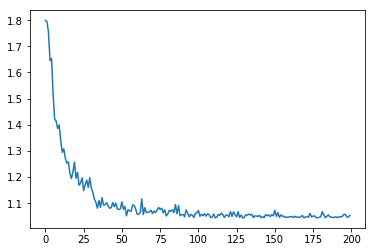

In [ ]:
# parse logfile to get loss
%matplotlib inline
print('Using the following log: ')
print(os.path.abspath('tensorflow.log'))

file = os.path.abspath('tensorflow.log')

losses = []

with open(file, 'r') as f:
    data = f.readlines()
for line in data:
    if 'loss = ' in line:
        # print(line)
        line = line.split()
        val = line[2]
        if ',' not in val and 'for' not in val:
            losses.append(float(val))

plt.plot(losses)

end_time = time.time()
elapsed = end_time - start_time
print('Time elapsed {} mins {} secs'.format(int(elapsed/60), int(elapsed%60)))